<a href="https://colab.research.google.com/github/Abyan12/Hybrid-Learning-Personality/blob/main/Hybrid_Learning_Personality_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
import io
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

# **Upload Raw Dataset**

In [ ]:
print("\nUpload file dataset mentah :")

uploaded = files.upload()

filename = list(uploaded.keys())[0]
file_content = uploaded[filename]

df = pd.read_csv(io.BytesIO(file_content))

print(f"\nDataset '{filename}' berhasil dimuat.")


Upload file dataset mentah :


Saving reddit_personality_10k.csv to reddit_personality_10k.csv

Dataset 'reddit_personality_10k.csv' berhasil dimuat.


# **Data Preprocessing**

In [ ]:
for col in ['title', 'content', 'label']:
    if col not in df.columns:
        raise KeyError(f"Kolom '{col}' tidak ditemukan di dataset. Pastikan dataset memiliki kolom title, content, label.")

df['title'] = df['title'].fillna('').astype(str)
df['content'] = df['content'].fillna('').astype(str)
df['full_text'] = (df['title'] + ' ' + df['content']).str.strip()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

custom_stopwords = {'im','ive','dont','like','get','really','dont','ive','know','want','got','cant','thing','also','just','one','many'}
stop_words.update(custom_stopwords)

contractions = {
    "i'm":"i am","you're":"you are","he's":"he is","she's":"she is","it's":"it is",
    "we're":"we are","they're":"they are","can't":"cannot","won't":"will not",
    "n't":" not","'re":" are","'s":" is","'d":" would","'ll":" will","'t":" not","'ve":" have","'m":" am"
}

def expand_contractions(text):
    # replace common contractions (lowercased expected)
    for k,v in contractions.items():
        text = re.sub(re.escape(k), v, text)
    return text

def preprocess_text(text, relevant_words=None):
    # text: already str
    text = text.lower()
    text = expand_contractions(text)
    # remove URLs, mentions, reddit references
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'\@\w+|\/r\/\w+|\/u\/\w+', ' ', text)
    # keep letters and spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    # normalize repeated spaces
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]
    if relevant_words:
        tokens = [t for t in tokens if t in relevant_words]
    return ' '.join(tokens)

relevant_words = None
# Example: relevant_words = {"introvert","extrovert","alone","quiet","shy","reading","talk","social","friend","party","home","conversation","group","outgoing","thinking"}

print("Start preprocessing...")
df['cleaned_text'] = df['full_text'].apply(lambda t: preprocess_text(t, relevant_words=relevant_words))
print("Preprocessing selesai.")

df = df.dropna(subset=['cleaned_text','label'])
df = df[df['cleaned_text'].str.strip() != '']
df['label'] = df['label'].astype(str).str.lower().str.strip()

print(f"Total data valid setelah preprocessing: {len(df)}")
print(df['label'].value_counts())

Start preprocessing...
Preprocessing selesai.
Total data valid setelah preprocessing: 6160
label
introvert    3229
extrovert    2931
Name: count, dtype: int64


# **Exploration Data Analysis (EDA)**


--- Memulai Exploratory Data Analysis (EDA) ---


/tmp/ipython-input-1106783841.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


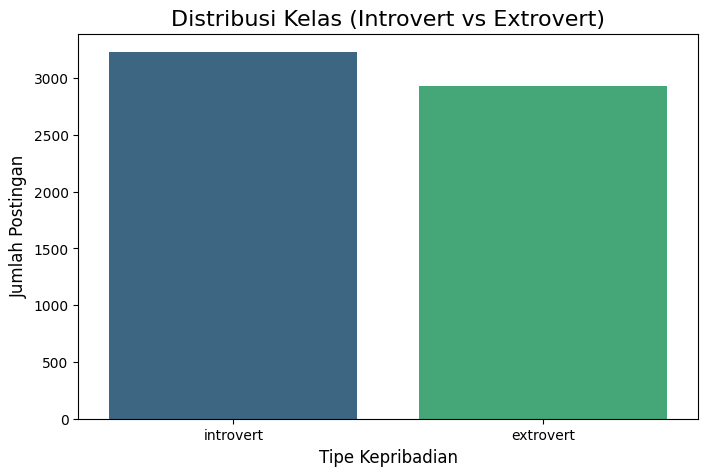

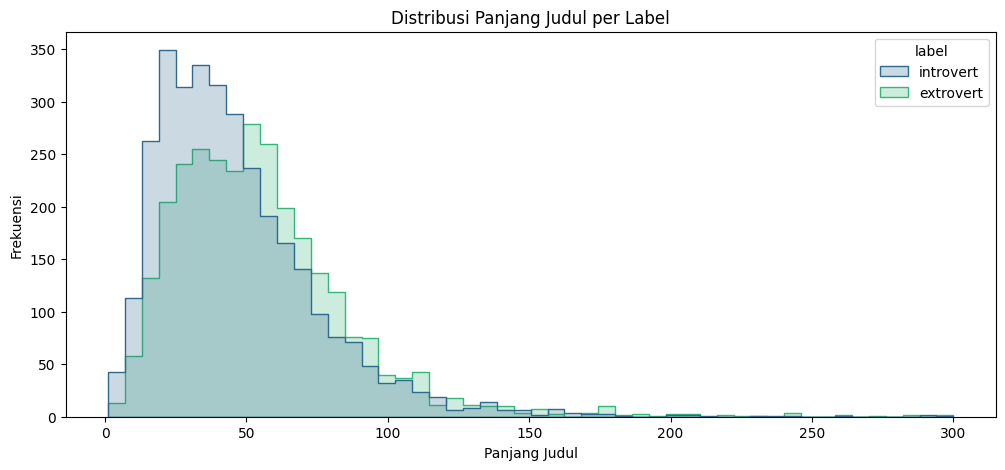

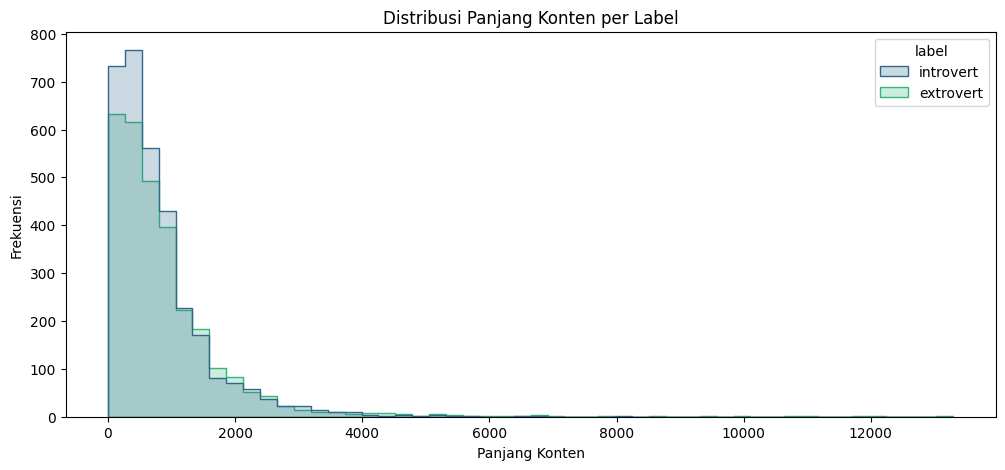

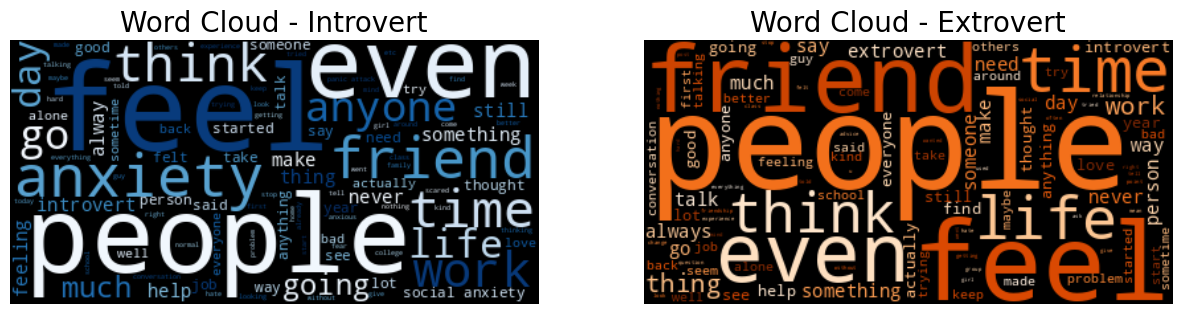


Top 10 Bigram untuk Kelas Introvert:
           Bigram  Frekuensi
0  social anxiety        653
1    panic attack        299
2     make friend        159
3       make feel        150
4          gon na        148
5          wan na        138
6     high school        121
7        year old        119
8        year ago        110
9      small talk        109

Top 10 Bigram untuk Kelas Extrovert:
           Bigram  Frekuensi
0     make friend        240
1          wan na        180
2     high school        140
3   social medium        139
4  social anxiety        133
5    social skill        129
6       make feel        123
7    friend group        121
8     talk people        121
9        year old        113

--- EDA Selesai ---


In [ ]:
print("\n--- Memulai Exploratory Data Analysis (EDA) ---")

# 1. Distribusi Kelas
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribusi Kelas (Introvert vs Extrovert)', fontsize=16)
plt.xlabel('Tipe Kepribadian', fontsize=12)
plt.ylabel('Jumlah Postingan', fontsize=12)
plt.show()

# 2. Analisis Panjang Teks per Label
df['title_length'] = df['title'].astype(str).str.len()
df['content_length'] = df['content'].astype(str).str.len()

plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='title_length', hue='label', bins=50, element='step', palette='viridis')
plt.title('Distribusi Panjang Judul per Label')
plt.xlabel('Panjang Judul')
plt.ylabel('Frekuensi')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='content_length', hue='label', bins=50, element='step', palette='viridis')
plt.title('Distribusi Panjang Konten per Label')
plt.xlabel('Panjang Konten')
plt.ylabel('Frekuensi')
plt.show()

# 3. Word Cloud per Kelas (kata unik)
def generate_wordcloud(text, title, color):
    wc = WordCloud(max_words=100, background_color="black", colormap=color).generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')

introvert_text = " ".join(df[df['label'] == 'introvert']['cleaned_text'])
extrovert_text = " ".join(df[df['label'] == 'extrovert']['cleaned_text'])

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
generate_wordcloud(introvert_text, 'Word Cloud - Introvert', 'Blues')
plt.subplot(1, 2, 2)
generate_wordcloud(extrovert_text, 'Word Cloud - Extrovert', 'Oranges')
plt.show()

# 4. Analisis N-gram (Bigram unik)
def get_top_ngrams(corpus, n=None, ngram_range=(2,2)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if len(set(word.split())) > 1]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams_introvert = get_top_ngrams(df[df['label'] == 'introvert']['cleaned_text'], n=10)
top_bigrams_extrovert = get_top_ngrams(df[df['label'] == 'extrovert']['cleaned_text'], n=10)

df_bigrams_introvert = pd.DataFrame(top_bigrams_introvert, columns=['Bigram', 'Frekuensi'])
df_bigrams_extrovert = pd.DataFrame(top_bigrams_extrovert, columns=['Bigram', 'Frekuensi'])

print("\nTop 10 Bigram untuk Kelas Introvert:")
print(df_bigrams_introvert)
print("\nTop 10 Bigram untuk Kelas Extrovert:")
print(df_bigrams_extrovert)

print("\n--- EDA Selesai ---")

# **Train-Split Data and TF-IDF vectorize**


Data latih: 4928, Data uji: 1232


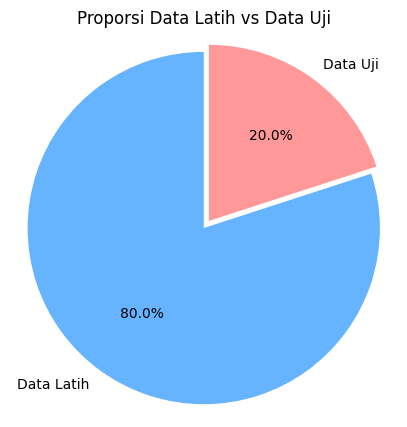

In [ ]:
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData latih: {len(X_train)}, Data uji: {len(X_test)}")

# Hitung jumlah data latih dan uji
train_count = len(X_train)
test_count = len(X_test)

# Data untuk visualisasi
labels = ['Data Latih', 'Data Uji']
sizes = [train_count, test_count]
colors = ['#66b3ff', '#ff9999']

# Visualisasi dengan Pie Chart
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0))
plt.title('Proporsi Data Latih vs Data Uji')
plt.axis('equal')
plt.show()

tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

/tmp/ipython-input-1812849538.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='word', data=introvert_tfidf, ax=axes[0], palette='Blues_r')
/tmp/ipython-input-1812849538.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='word', data=extrovert_tfidf, ax=axes[1], palette='Oranges_r')


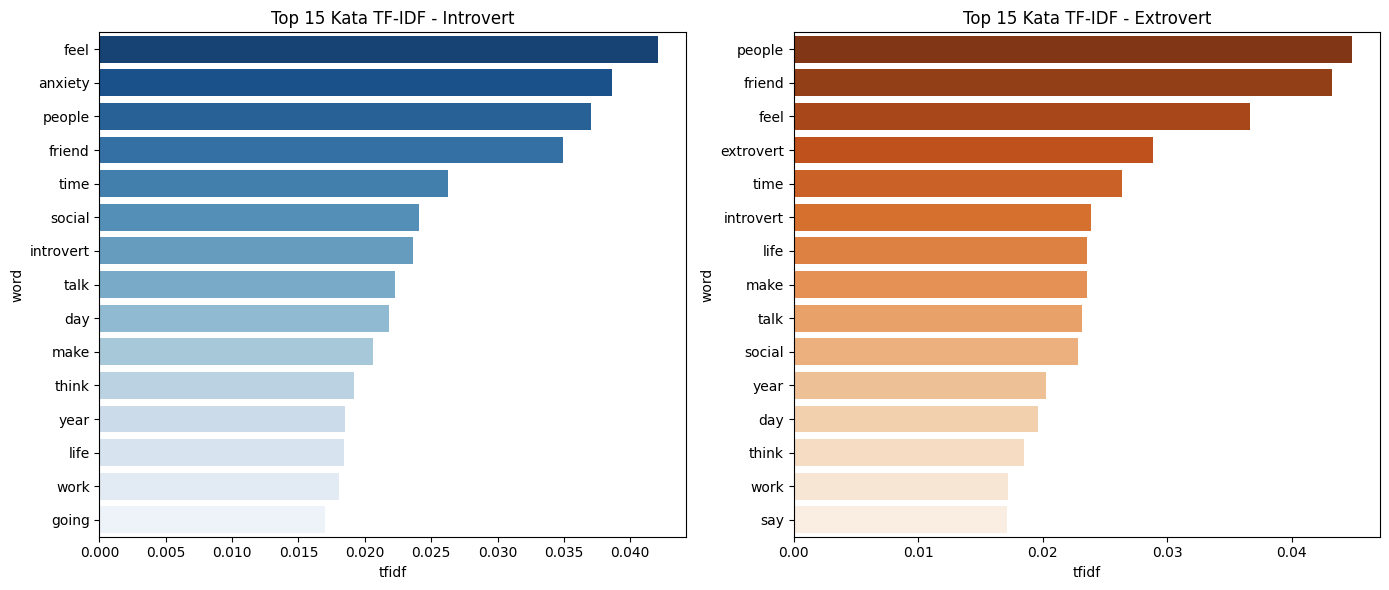

/tmp/ipython-input-1812849538.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='chi2', y='feature', data=top_int, ax=axes[0], palette='Blues_r')
/tmp/ipython-input-1812849538.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='chi2', y='feature', data=top_ext, ax=axes[1], palette='Oranges_r')


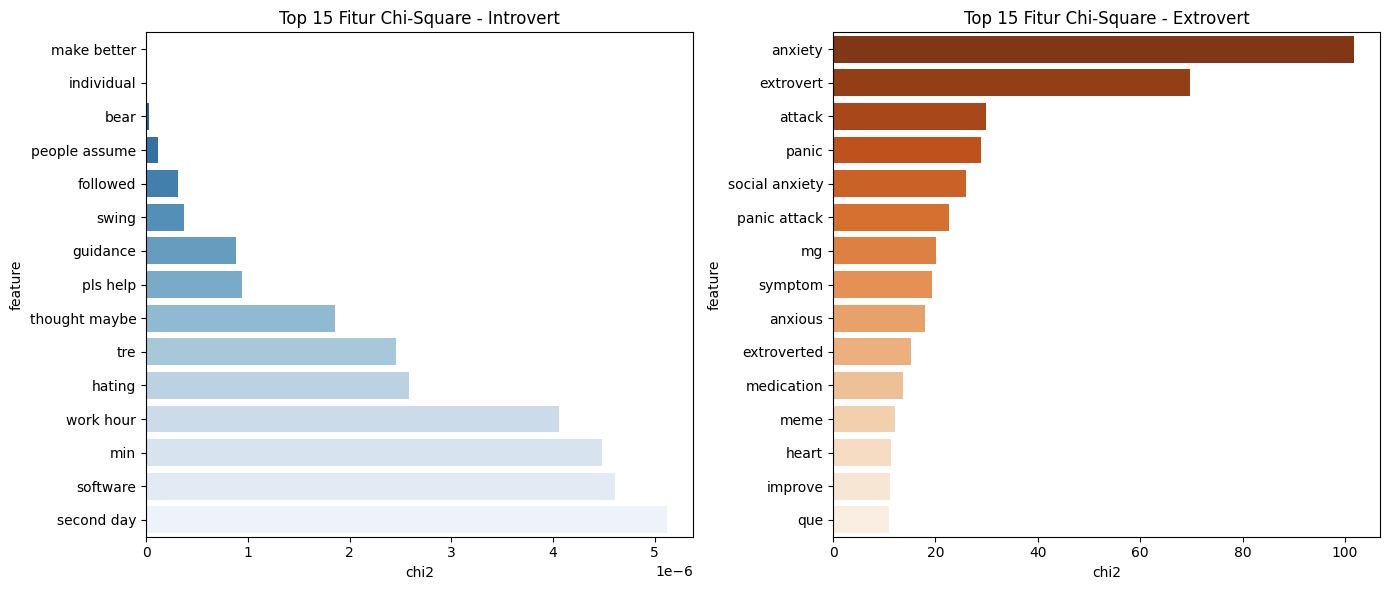

In [ ]:
y_num = y.map({'introvert':0,'extrovert':1})
y_train_num = y_train.map({'introvert':0,'extrovert':1})
X_for_chi = tfidf_vectorizer.transform(df['cleaned_text'])
chi2_scores, pvals = chi2(X_for_chi, y_num.loc[df.index])
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
chi2_df = pd.DataFrame({'feature': feature_names, 'chi2': chi2_scores, 'pval': pvals})
# top features (highest chi2 => most associated with class 1 (extrovert) generally)
top_ext = chi2_df.sort_values('chi2', ascending=False).head(15)
top_int = chi2_df.sort_values('chi2', ascending=True).head(15)

def get_top_tfidf_words(corpus, top_n=15):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(corpus)
    feature_names = np.array(tfidf.get_feature_names_out())
    mean_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    top_indices = mean_scores.argsort()[::-1][:top_n]
    return pd.DataFrame({'word': feature_names[top_indices], 'tfidf': mean_scores[top_indices]})

# Top TF-IDF Introvert
introvert_tfidf = get_top_tfidf_words(df[df['label'] == 'introvert']['cleaned_text'])
# Top TF-IDF Extrovert
extrovert_tfidf = get_top_tfidf_words(df[df['label'] == 'extrovert']['cleaned_text'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x='tfidf', y='word', data=introvert_tfidf, ax=axes[0], palette='Blues_r')
axes[0].set_title("Top 15 Kata TF-IDF - Introvert")
sns.barplot(x='tfidf', y='word', data=extrovert_tfidf, ax=axes[1], palette='Oranges_r')
axes[1].set_title("Top 15 Kata TF-IDF - Extrovert")
plt.tight_layout()
plt.show()

# Visualisasi Top 15 Fitur berdasarkan Chi-Square untuk Introvert & Extrovert
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x='chi2', y='feature', data=top_int, ax=axes[0], palette='Blues_r')
axes[0].set_title("Top 15 Fitur Chi-Square - Introvert")
sns.barplot(x='chi2', y='feature', data=top_ext, ax=axes[1], palette='Oranges_r')
axes[1].set_title("Top 15 Fitur Chi-Square - Extrovert")
plt.tight_layout()
plt.show()


# **Tuning and Modelling**

In [ ]:
print("\nHyperparameter Tuning")

# Naive Bayes (fit on TF-IDF)
param_grid_nb = {'alpha':[0.1,0.5,1.0,1.5,2.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train_tfidf, y_train)
best_nb = grid_nb.best_estimator_
print("NB best params:", grid_nb.best_params_, " best score:", grid_nb.best_score_)

# SVM with linear kernel (SVC with probability=True so it can be used in soft voting)
param_grid_svm = {'C':[0.1,1,10,100]}
grid_svm = GridSearchCV(SVC(kernel='linear', probability=True, random_state=42), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_tfidf, y_train)
best_svm = grid_svm.best_estimator_
print("SVM best params:", grid_svm.best_params_, " best score:", grid_svm.best_score_)

hybrid = VotingClassifier(estimators=[('nb', best_nb), ('svm', best_svm)], voting='soft', n_jobs=-1)
hybrid.fit(X_train_tfidf, y_train)

joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(hybrid, 'hybrid_nb_svm_model.joblib')


Hyperparameter Tuning
NB best params: {'alpha': 1.5}  best score: 0.7360037479021015
SVM best params: {'C': 0.1}  best score: 0.750816610207885


['hybrid_nb_svm_model.joblib']

# **Model Evaluation**


Model: Hybrid Tuned
Accuracy: 0.7435
              precision    recall  f1-score   support

   extrovert       0.72      0.75      0.73       586
   introvert       0.76      0.74      0.75       646

    accuracy                           0.74      1232
   macro avg       0.74      0.74      0.74      1232
weighted avg       0.74      0.74      0.74      1232



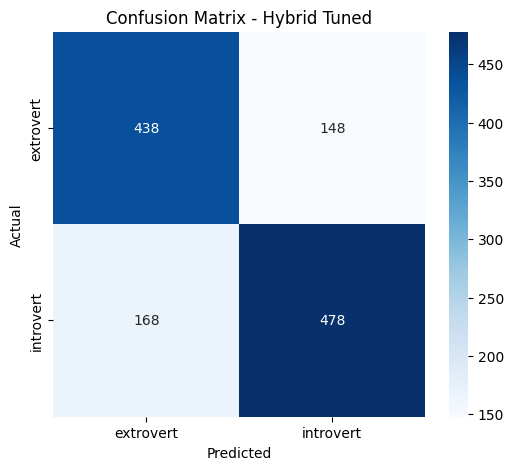

In [ ]:
models = {"Hybrid Tuned": hybrid}
class_names = sorted(df['label'].unique())

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nModel: {name}\nAccuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

**ROC Curve Comparison**

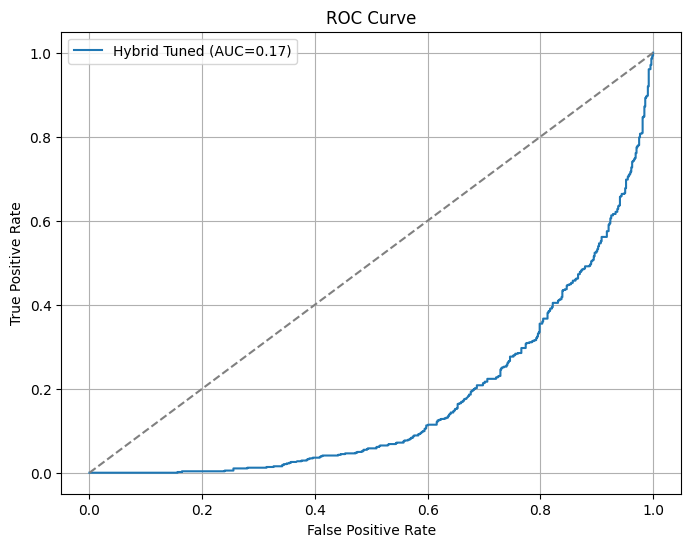

In [ ]:
# ROC curve: need numeric y_test & predict_proba
y_test_num = y_test.map({'introvert':0,'extrovert':1})
plt.figure(figsize=(8,6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_tfidf)[:,1]
        fpr, tpr, _ = roc_curve(y_test_num, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(); plt.show()

**Cross Validation**

In [ ]:
# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Hybrid Tuned CV Accuracy: 0.7510 ± 0.0099


**Feature Importance (TF-IDF top features)**

Urutan kelas: ['extrovert' 'introvert']


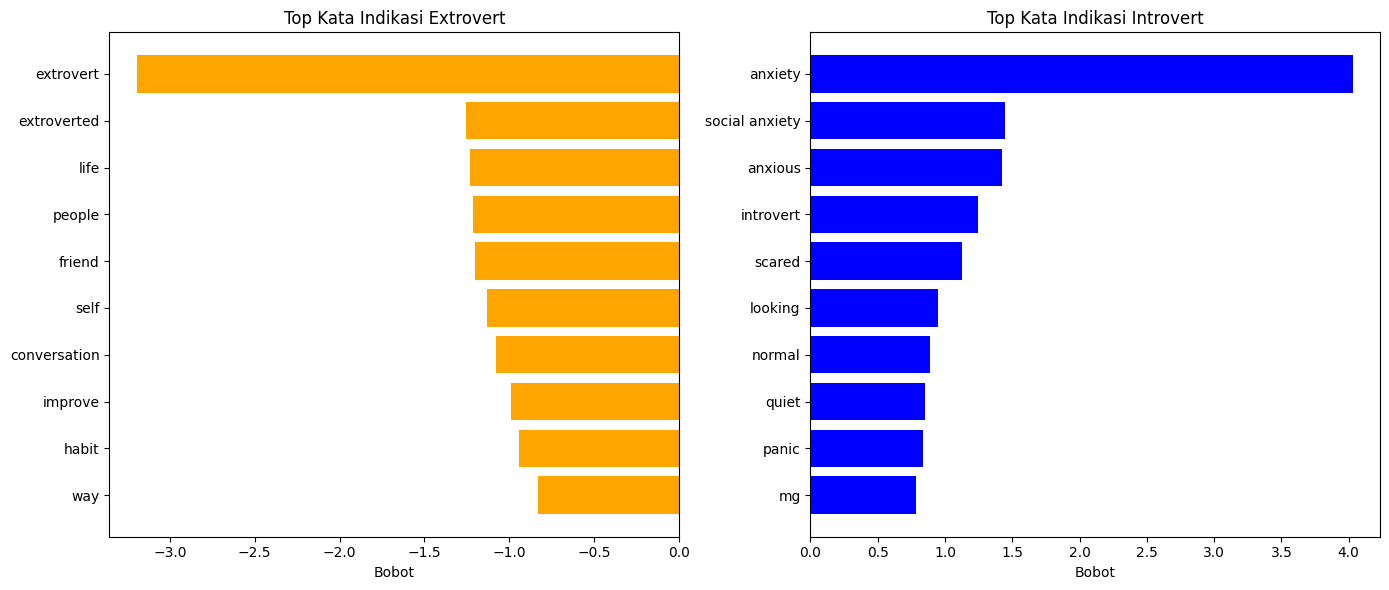

In [ ]:
# Ambil nama fitur dari TF-IDF
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Ambil bobot dari model SVM
coef = best_svm.coef_.toarray().ravel()

# Cek urutan kelas
classes = best_svm.classes_
print("Urutan kelas:", classes)

# Tentukan mana yang positif = Extrovert, mana yang negatif = Introvert
if classes[1].lower() == 'extrovert':
    # Positif = Extrovert, Negatif = Introvert
    top_extrovert_idx = np.argsort(coef)[-10:][::-1]
    top_introvert_idx = np.argsort(coef)[:10]
else:
    # Positif = Introvert, Negatif = Extrovert
    top_extrovert_idx = np.argsort(coef)[:10]
    top_introvert_idx = np.argsort(coef)[-10:][::-1]

# Ambil kata & bobot
extrovert_words = feature_names[top_extrovert_idx]
extrovert_scores = coef[top_extrovert_idx]

introvert_words = feature_names[top_introvert_idx]
introvert_scores = coef[top_introvert_idx]

# Plot bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Extrovert
axes[0].barh(extrovert_words[::-1], extrovert_scores[::-1], color="orange")
axes[0].set_title("Top Kata Indikasi Extrovert")
axes[0].set_xlabel("Bobot")

# Introvert
axes[1].barh(introvert_words[::-1], introvert_scores[::-1], color="blue")
axes[1].set_title("Top Kata Indikasi Introvert")
axes[1].set_xlabel("Bobot")

plt.tight_layout()
plt.show()


 **Data Graphic**


Membuat visualisasi laporan klasifikasi...


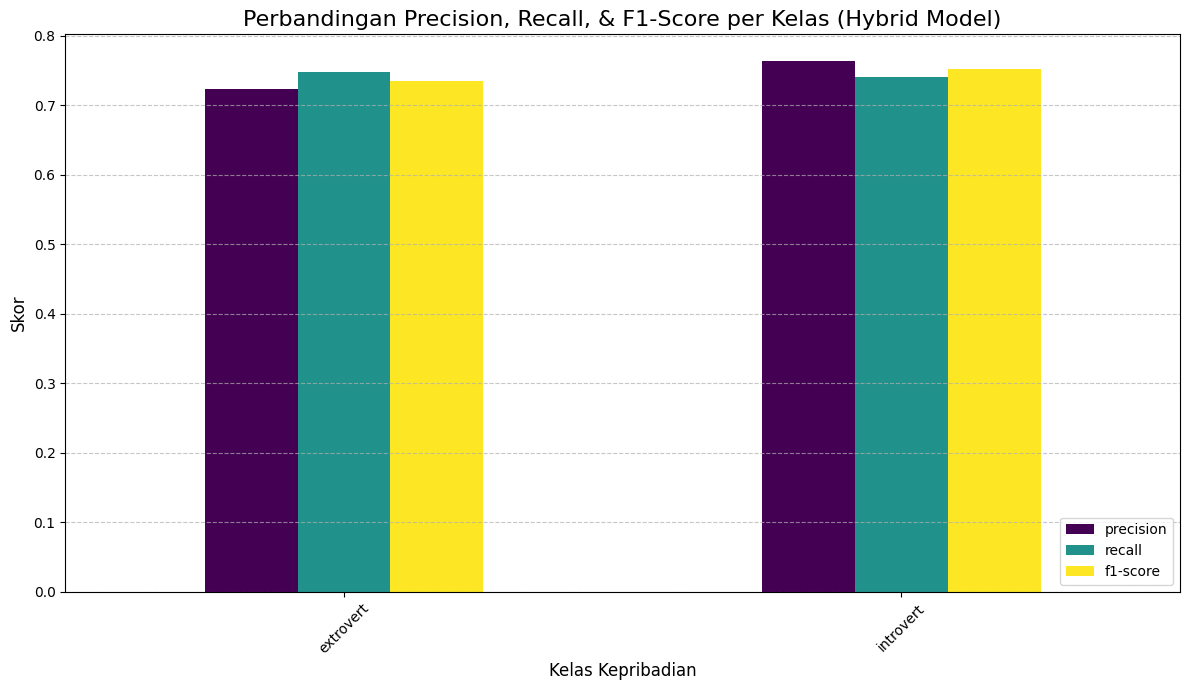

In [ ]:
print("\nMembuat visualisasi laporan klasifikasi...")

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Buang baris accuracy, macro avg, weighted avg agar fokus ke kelas
report_df = report_df.drop(['accuracy','macro avg','weighted avg'])

# Plot
report_df[['precision','recall','f1-score']].plot(kind='bar', figsize=(12,7), colormap='viridis')

plt.title("Perbandingan Precision, Recall, & F1-Score per Kelas (Hybrid Model)", fontsize=16)
plt.ylabel("Skor", fontsize=12)
plt.xlabel("Kelas Kepribadian", fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Error Analysis**

In [ ]:
# ====== Error analysis function ======
def error_analysis(model, X_test_raw, X_test_vect, y_test):
    y_pred = model.predict(X_test_vect)
    mask = (y_test != y_pred)
    df_err = pd.DataFrame({
        'text': X_test_raw[mask],
        'true': y_test[mask],
        'pred': y_pred[mask]
    })
    return df_err

errors = error_analysis(hybrid, X_test, X_test_tfidf, y_test)
print("\nContoh error (max 10):")
print(errors.head(10))


Contoh error (max 10):
                                                   text       true       pred
486   grass always greener started new job last mont...  introvert  extrovert
2131  stop looking awkward every video picture fit n...  introvert  extrovert
5907               classic day certain community coming  extrovert  introvert
301   introvert extroverted partner work go period n...  introvert  extrovert
5127  removed reddit removed reddit account violatin...  extrovert  introvert
822   think idea introvert shy come u introvert peop...  introvert  extrovert
428   ended indirectly kicking mother vegetable edit...  introvert  extrovert
5160  turn still live parent moved started working w...  extrovert  introvert
1598  please tell friend year close starting vibe us...  introvert  extrovert
5862  trouble germany something called class confere...  extrovert  introvert


**Error Visualization**

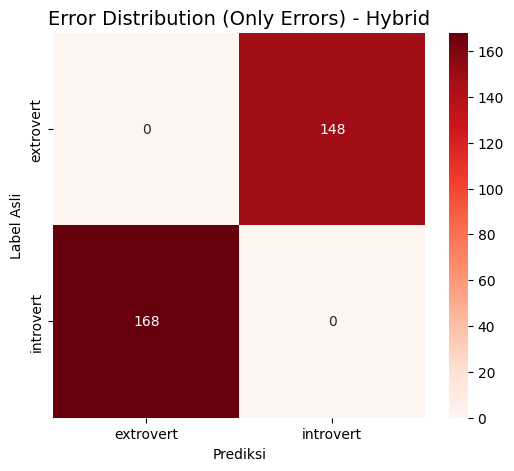

In [ ]:
def plot_error_distribution_only(model, name):
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=class_names)

    # Buat salinan confusion matrix untuk error saja (off-diagonal)
    error_only_cm = cm.copy()
    np.fill_diagonal(error_only_cm, 0)

    plt.figure(figsize=(6, 5))
    sns.heatmap(error_only_cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(f"Error Distribution (Only Errors) - {name}", fontsize=14)
    plt.xlabel("Prediksi")
    plt.ylabel("Label Asli")
    plt.show()

plot_error_distribution_only(hybrid, "Hybrid")

In [ ]:
sample_text = ["I liked to hangout with my friends", "I liked to be alone at home reading"]
sample_tfidf = tfidf_vectorizer.transform([preprocess_text(t) for t in sample_text])
sample_preds = hybrid.predict(sample_tfidf)
for t,p in zip(sample_text, sample_preds):
    print(f"\nText: {t}\nPredicted: {p}")

NameError: name 'tfidf_vectorizer' is not defined